# GPU Version

In [ ]:
!nvcc chi2.cu -o chi2

Time: 0.010783


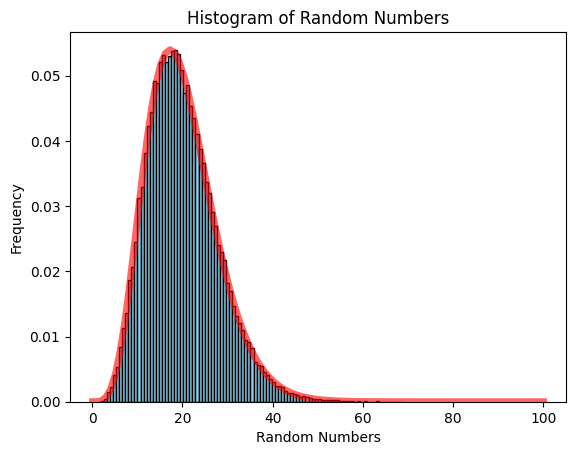

In [ ]:
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import chi2
from scipy.special import iv
import time

n = 100000
d = 10
l =1
# Convert numeric arguments to strings
d_str = str(d)
n_str = str(n)
lambda_str = str(l)

# Running the CUDA script and capture the output
result = subprocess.run(['./chi2', d_str, n_str, lambda_str], capture_output=True, text=True)

# Extract the output containing random numbers
output = result.stdout.split('\n')
random_numbers = [float(line.strip()) for line in output[:-2] if line.strip()]  # Convert to float and remove empty lines
print(output[-2])

# True density
def decentrelized_chi2(x, d , l):
    bessel = iv(d/2-1, np.sqrt(x*l))
    return 1/2*np.exp(-(x+l)/2)*((x/l)**(d/4-1/2))*bessel

# Plotting the histogram and distribution
plt.hist(random_numbers , density=True ,bins = 100, color='skyblue', edgecolor='black')
x = np.linspace(0.1,100, 100)
plt.plot(x, decentrelized_chi2(x, d , l), 'r-', lw=5, alpha=0.6, label='Theoretical Distribution')
plt.xlabel('Random Numbers')
plt.ylabel('Frequency')
plt.title('Histogram of Random Numbers')
plt.show()


# CPU Version (For comparison)

In [ ]:
def GS_star(alpha):
    b = (alpha + np.e )/np.e
    y = np.random.uniform(0,1,1) * b
    if y <= 1:
        x = (y)**(1/alpha)
        w = np.random.exponential(1,1)
        if w > x:
            return x
    else:
        x = -np.log((b-y)/alpha)
        w = np.random.uniform(0,1,1)**(1/(alpha-1))
        if w <= x:
            return x

# use if alpha > 1

def GKM1(alpha):
    a = alpha - 1
    b = (alpha - 1/(6*alpha))/a
    m = 2/a
    d= m + 2

    while True:
        x = np.random.uniform(0,1,1)
        y = np.random.uniform(0,1,1)
        v = b*y/x
        if m*x - d + v + 1/v <= 0:
            return a*v
        if m*np.log(x) - np.log(v) + v - 1 <= 0:
            return a*v


def GKM2(alpha):
    a = alpha - 1
    b = ( alpha - 1/(6*alpha) ) / a
    m = 2/a
    d = m + 2
    f = np.sqrt(alpha)
    while( True ):
        while( True ):
            #generate X uniform in (0,1)
            X = np.random.rand()
            Yprime = np.random.rand()
            Xprime = Yprime + (1 - 1.857764 * X) / f
            if (Xprime > 0 and Xprime < 1):
                break
        v = b*Yprime/Xprime
        if(m*Xprime - d + v + 1/v <= 0):
            break
        if(m * np.log(Xprime) - np.log(v) + v - 1 <= 0):
            break
    return a * v

def GKM3(alpha, alpha0 = 2.5):
  if alpha <= alpha0 :
    return GKM1(alpha)
  else :
    return GKM2(alpha)

def simchi2(d):
    # xi^2_d === Gamma(d/2,2)
    if d/2 < 1:
        return GS_star(d/2)*2
    if d/2 > 1:
        return GKM3(d/2)*2
    if d/2 == 1:
        return np.random.exponential(2,1)

def non_centrical_chi_2(d , lambda_):
    # d is the number of degrees of freedom
    N = np.random.poisson(1/2*lambda_,1)
    x = simchi2(d+2*N)
    return x

# Plotting the chi 2 distribution
d = 10
n = 100000
l =10
chi_2 = np.zeros(n)

start = time.time()
for i in range(n):
    chi_2[i] = non_centrical_chi_2(d,l)
end = time.time()
print("Time taken"  , end - start)

<ipython-input-3-db4730dde6ad>:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_2[i] = non_centrical_chi_2(d,l)


Time taken 11.204220294952393


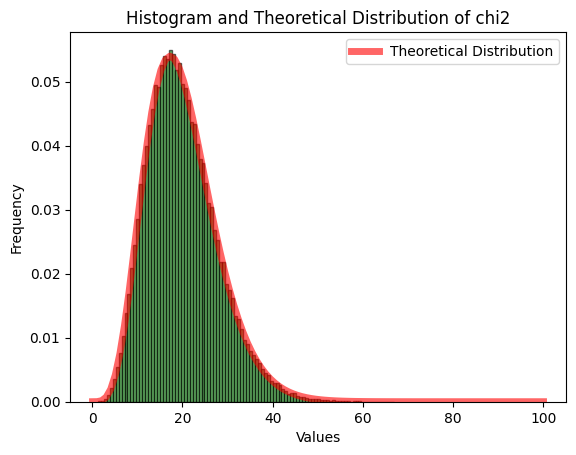

In [ ]:
plt.hist(chi_2, bins=100, density=True, alpha=0.6, color='g', edgecolor='black')
x = np.linspace(0.1, 100, 100)
plt.plot(x, decentrelized_chi2(x, d , l), 'r-', lw=5, alpha=0.6, label='Theoretical Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram and Theoretical Distribution of chi2')
plt.legend()
plt.show()
